# Solutions to exercises

In [1]:
%matplotlib inline 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import stochpy 

def extract_data(smod, ntps= 100):
    '''
    extracts trajectories onto regularly spaced time points
    
    Returns
    --
    gridded_data: a list of numpy arrays, one for each species where 
        each column corresponds to a trajectory
    t: the corresponding time points 
    species: a list of the chemical species simulated
    '''
    smod.GetRegularGrid(ntps)
    species= smod.data_stochsim_grid.species_labels
    ntraj= smod.sim_trajectories_done
    t= smod.data_stochsim_grid.getTime()
    # grid data
    gridded_data= [np.transpose([smod.data_stochsim_grid.species[i][j] 
                             for j in range(ntraj)]) 
               for i in range(len(species))]
    return gridded_data, t, species


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

## Question 1.1

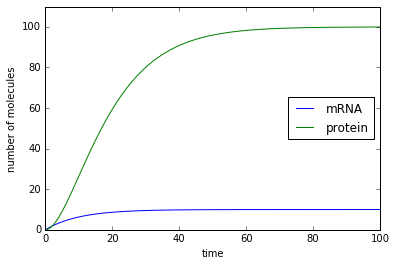

In [2]:
# gene expression
def ge(y, t, u, d0, v, d1):
    dydt = np.empty(2)
    dydt[0] = -y[0]*d0 + u
    dydt[1] = -y[1]*d1 + v*y[0]
    return dydt

to= np.linspace(0, 100, 300)   
res= odeint(ge, [0,0], to, (1, 0.1, 1, 0.1))
plt.plot(to, res)
plt.ylabel('number of molecules')
plt.xlabel('time')
plt.legend(['mRNA', 'protein'], loc= 'center right')
plt.ylim([0, 110])
plt.show()

## Question 1.2

In [3]:
smod= stochpy.SSA()
smod.Model('gene_expression.psc', dir= 'model_files')

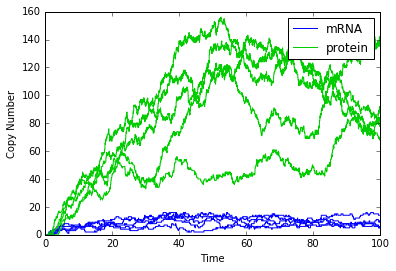

In [4]:
# run simulation 
smod.DoStochSim(end= 100, mode= 'time', trajectories= 5, quiet= False)
smod.PlotSpeciesTimeSeries()

In [5]:
smod.DoStochSim(end= 100,mode= 'time', trajectories= 10, quiet= False)
data, t, species= extract_data(smod, 100)

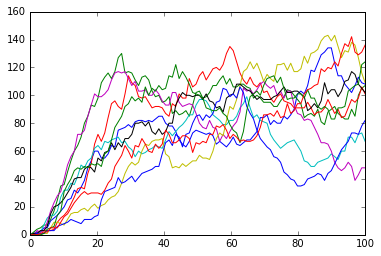

In [6]:
# plot the trajectories for protein
plt.plot(t, data[1])

## Question 1.3

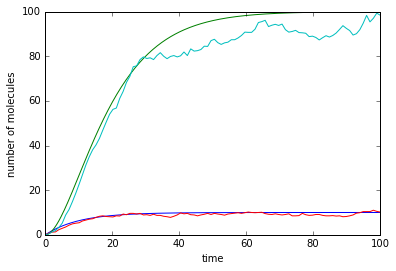

In [7]:
# compare means with solution of ordinary differential equations
plt.plot(to, res, t, np.mean(data[0], axis= 1), t, np.mean(data[1], axis=1))
plt.ylabel('number of molecules')
plt.xlabel('time')

In [8]:
params = [[10, 0.1], [1, 1], [0.1, 10]]
 
# run simulation for each set of parameters
alldata= []
for i, p in enumerate(params):
    smod.ChangeParameter('u', p[0])
    smod.ChangeParameter('v', p[1])
    smod.DoStochSim(end= 100, mode= 'time', trajectories= 100, quiet= False)
    data, t, species= extract_data(smod)
    alldata.append([data[0], data[1]])

## Question 1.4

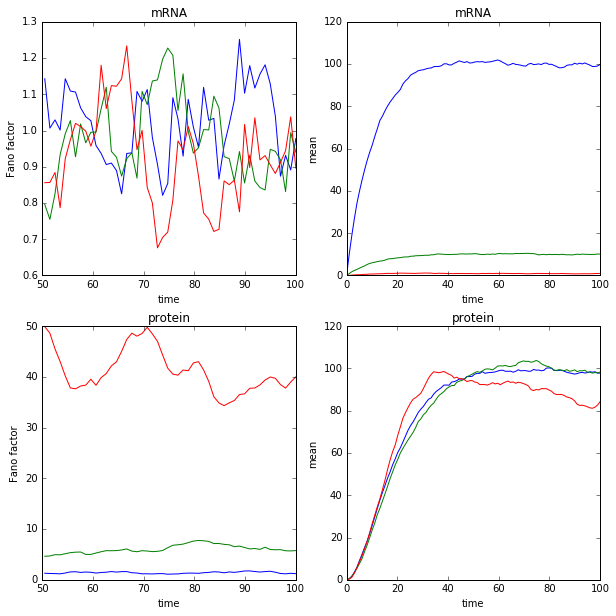

In [9]:
# time range for calculating Fano factor
tps= range(50, 100)

# plot results
plt.figure(figsize= (10, 10))
for di in range(len(alldata)):
    fi= 1
    for si in range(2):
        plt.subplot(2, 2, fi)
        plt.plot(t[tps], np.var(alldata[di][si][tps, :], axis= 1)
                 /np.mean(alldata[di][si][tps, :], axis= 1))
        plt.ylabel('Fano factor')
        plt.xlabel('time')
        plt.title(species[si])
        plt.subplot(2, 2, fi+1)
        plt.plot(t, np.mean(alldata[di][si], axis= 1))
        plt.ylabel('mean')
        plt.xlabel('time')
        plt.title(species[si])
        fi += 2
plt.show()

## Question 1.5 & 1.6

In [10]:
import pickle
dd= pickle.load(open("pkls/gene_expression_10000.pkl", "rb"))
params= dd['parameters']
t= dd['timepoints']
data= dd['data']

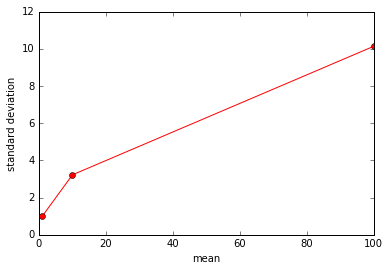

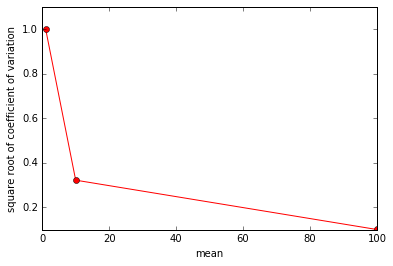

In [11]:
# for mRNA
mn= [np.mean(data[i][0][-1, :]) for i in range(len(params))]
std= [np.std(data[i][0][-1, :]) for i in range(len(params))]
rcv= np.array(std)/np.array(mn)

plt.figure()
plt.plot(mn, std, '-or')
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.show()

plt.figure()
plt.plot(mn, rcv,'-or')
plt.xlabel('mean')
plt.ylabel('square root of coefficient of variation')

## Question 2.1

In [12]:
def repressilator(y, t, a, b, d= 1):
    '''organised as [m1, p1, m2, p2, m3, p3]'''
    dydt= np.empty(len(y))
    for i in range(0, 5, 2):
        dydt[i]= -y[i]*d + a/(1 + (1 + y[(i+5)%6]**2))
        dydt[i+1]= b*(y[i] - y[i+1])
    return dydt    

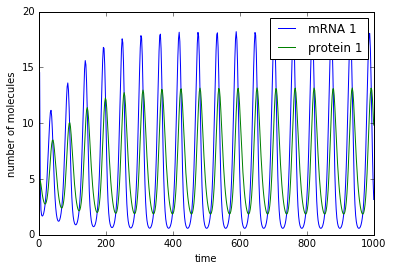

In [13]:
# do for loop of synthesis rates
to= np.linspace(0, 1000, 500)   
res= odeint(repressilator, [0, 1, 0, 0, 0, 0], to, args= (100, 0.1, 1))
plt.figure()
plt.plot(to, res[:, 0:2])
plt.ylabel('number of molecules')
plt.xlabel('time')
plt.legend(['mRNA 1','protein 1'])
plt.show()

## Question 2.2

In [14]:
# load model and run simulations
smod= stochpy.SSA()
smod.Model('repressilator.psc', dir= 'model_files')
smod.DoStochSim(end= 1000, mode= 'time', trajectories= 10, quiet= False)
data, t, species= extract_data(smod, 100)

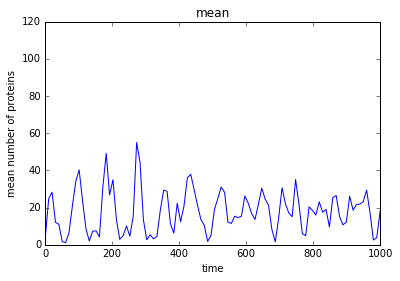

In [15]:
plt.figure()
plt.plot(t, np.mean(data[1], axis= 1))
plt.xlabel('time')
plt.ylabel('mean number of proteins')
plt.title('mean')
plt.ylim([0, 120])
plt.show()

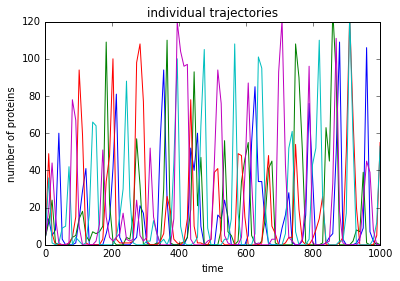

In [16]:
plt.figure()
plt.plot(t, data[1][:, 5:10])
plt.xlabel('time')
plt.ylabel('number of proteins')
plt.title('individual trajectories')
plt.ylim([0, 120])
plt.show()